In [62]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import os

from sklearn.feature_extraction import image
from sklearn.cluster import spectral_clustering
from skimage.io import imread, imsave
from skimage.color import rgb2gray
from numpy import array, ones, zeros, arctan2, pi, hstack, sum, finfo
from sklearn.svm import LinearSVC
from scipy.ndimage import convolve
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.model_selection import cross_val_score
from PIL import Image
from skimage import filters
from sys import argv
from sklearn.cluster import DBSCAN

In [20]:
if (not os.path.exists(workdir)):
    workdir = './frames_' + os.path.splitext(os.path.basename(argv[1]))[0]
os.mkdir(workdir)
os.system("ffmpeg -i " + argv[1] + ".mp4 -vf scale=320:240 " + argv[1] + "1.mp4")
n = os.system("ffmpeg -i " + argv[1] + '1.mp4 ' + workdir + '/frame%d.png')

In [43]:
def backgr(frms):
    shape = (len(frms), len(frms[0]), len(frms[0][0]))
    image = []
    for i in range(shape[1]):
        row = []
        for j in range(shape[2]):
            pixels = np.array([frame[i][j] for frame in frms])
            db = DBSCAN(eps=4, min_samples=4).fit(pixels)
            labels = db.labels_
            label_set = set(labels)
            lbcnt = {k: 0 for k in label_set}
            for k in labels:
                lbcnt[k] += 1
            choice = -1
            for k in label_set:
                if choice == -1 or lbcnt[choice] < lbcnt[k] and k != -1:
                    choice = k            
            if choice != -1:
                row.append(np.mean(np.array([pixels[k] for k in range(len(labels)) if labels[k] == choice]), axis=0))
            else:
                row.append(np.mean(pixels, axis=0))
        image.append(row)
    return image

In [53]:
frames = np.array([np.asarray(Image.open(os.path.join(workdir, 'frame' + str(f + 1) + '.png')))
                   for f in range(len(os.listdir(workdir)))])

2066.03685692 198


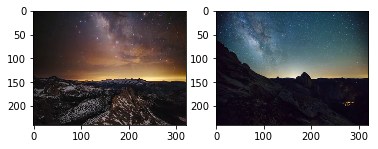

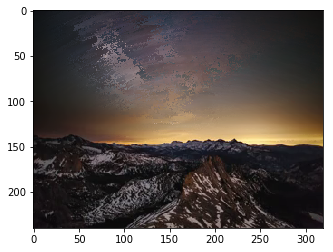

1545.54343977 392


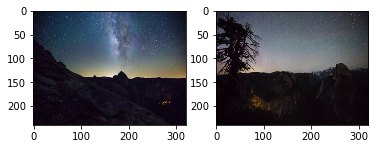

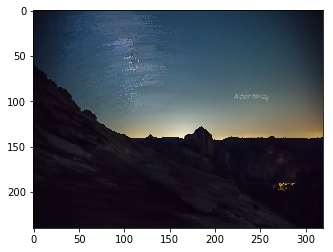

4259.44708164 585


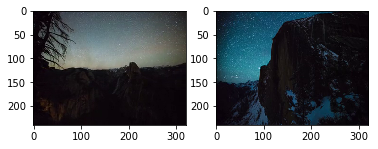

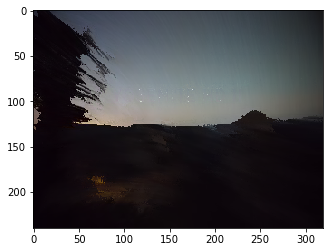

5058.8574952 774


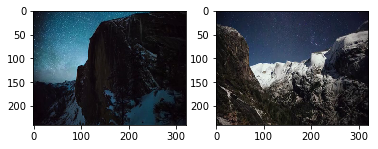

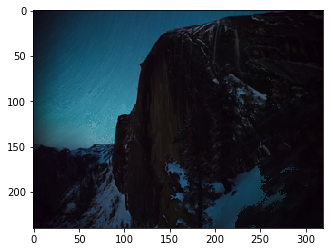

4172.28429572 963


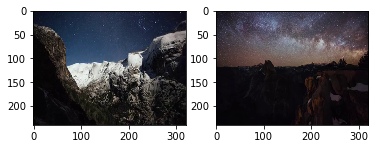

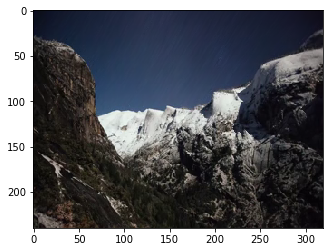

4695.77285578 1153


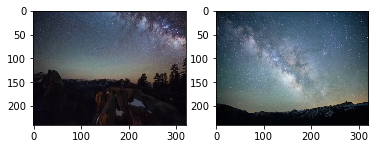

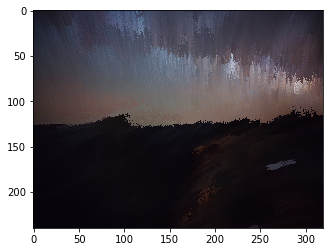

6


In [55]:
path = workdir + '/frame'
image1 = imread(path + "1.png")
k = 0
prev = 0
res = []
for i in range(2, 1200):
    image2 = imread(path + str(i) + ".png")
    img1 = rgb2gray(image1)
    img2 = rgb2gray(image2)
    if (sum((img1 - img2)**2) > 1500):
        k += 1
        if (i - prev > 10):
            if (k <= 7):
                print(sum((img1 - img2)**2), i)
                f = plt.figure()
                f.add_subplot(1,2, 1)
                plt.imshow(image1)
                f.add_subplot(1,2, 2)
                plt.imshow(image2)
                plt.show()
            ans = backgr(frames[prev:min(i-1, prev + 100)])
            ans = np.array(ans).astype(np.uint8)
            plt.imshow(ans)
            plt.show()
            res.append(ans)
        prev = i - 1
    image1 = image2
print(k)

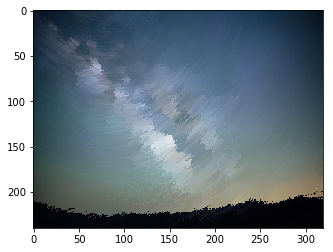

In [57]:
ans = backgr(frames[prev:min(i-1, prev + 100)])
ans = np.array(ans).astype(np.uint8)
plt.imshow(ans)
plt.show()
res.append(ans)

In [68]:
res = np.array(res).astype(np.uint8)
print(res.shape)
outdir = './loc_' + os.path.splitext(os.path.basename(argv[1]))[0]
if (not os.path.exists(outdir)):
    os.mkdir(outdir)
for i in range(res.shape[0]):
    imsave(outdir +'/loc' + str(i + 1) + '.png', res[i])

(7, 240, 320, 3)


In [ ]:
def extract_hog(img):
    img = resize(rgb2gray(img), (64, 64))
    ker_h = array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
    ker_v = array([[-1, -2, -1],
                   [0, 0, 0],
                   [1, 2, 1]])
    hor_d = convolve(img, ker_h)
    vert_d = convolve(img, ker_v)
    grad = (hor_d ** 2 + vert_d ** 2) ** 0.5
    grad_dir = arctan2(vert_d, hor_d)
    descr = array([])
    hist = zeros((8, 8, 8))
    for i in range(8):
        for j in range(8):
            for k in range(7):
                cell = (pi * (3 - k) / 4 <= grad_dir[i * 8:i * 8 + 8, j * 8:j * 8 + 8]) * (
                grad_dir[i * 8:i * 8 + 8, j * 8:j * 8 + 8] < pi * (4 - k) / 4)
                hist[i, j, k] = sum(cell * grad[i*8:i*8+8, j*8:j*8+8])
            cell = (-pi <= grad_dir[i * 8:i * 8 + 8, j * 8:j * 8 + 8]) * (
            grad_dir[i * 8:i * 8 + 8, j * 8:j * 8 + 8] <= pi * -3 / 4)
            hist[i, j, 7] = sum(cell * grad[i * 8:i * 8 + 8, j * 8:j * 8 + 8])
    for i in range(7):
        for j in range(7):
            vect = hstack((hist[i, j, :], hist[i, j + 1, :], hist[i + 1, j, :], hist[i + 1, j + 1, :]))
            vect /= ((sum(vect ** 2) + finfo(float).eps) ** 0.5)
            descr = hstack((descr, vect))
    return descr

In [ ]:
#for f in os.listdir(workdir):
#    os.remove(os.path.join(workdir, f))
#os.rmdir(workdir)